# Demonstration of Bayesian Gaussian Process QNM Fits

This is a tutorial / demonstration of the main functionality of this code 

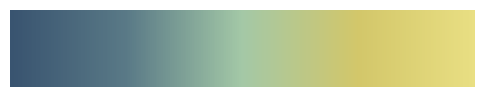

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1b1e3f",  # near-black indigo
    "#284575",  # deep soft blue
    "#3a7768",  # smoky teal
    "#89a04c",  # olive green
    "#d1c75f"   # dusty golden
]

colors2 = [

    "#0D1B2A",
    "#3C3C8A",
    "#5B2A7B",
    "#8C4D7E",
    "#B47C8F"

]

colors3 = ["#2A3C4C", "#3C6E63", "#6B9B62", "#B8C561", "#EFE9B0"] 

colors4 = [
    "#101B3F",  # deep navy
    "#1C2F5C",  # indigo steel
    "#2E5E5E",  # teal
    "#6B9B62",  # sage
    "#A6B85A",  # olive
    "#EDE7A1"   # pastel yellow
]

colors5 = [
    "#1C2B45",  # softened navy blue
    "#605F9E",  # soft indigo-violet
    "#855B94",  # lavender eggplant
    "#B07B9C",  # mauve rose
    "#D1A9B2"   # pastel dusty pink
]

colors6 = [
    "#0A122A",  # deeper, cooler navy
    "#1A2F4A",  # elegant indigo blue
    "#2D5555",  # softened teal
    "#68915F",  # refined sage green
    "#A4B848",  # slightly warmer olive
    "#F1E88B"   # creamy but more luminous yellow
]

final_palette = [
    "#0A122A",  # deep navy
    "#2A3C4C",  # muted twilight blue-teal
    "#3C6E63",  # cool, smoky teal
    "#6B9B62",  # soft sage
    "#AEBB57",  # softened olive
    "#E3D86E"   # toned-down yellow
]

pastel_palette_final = [
    "#395470",  # soft viridis-style blue
    "#5A7A87",  # pastel twilight blue-teal
    "#A4C9A7",  # pastel sage
    "#D3C76A",  # pastel olive
    "#E9DF83",  # slightly darker pastel yellow
]

cmap_name = "blue_pink"

cmap = LinearSegmentedColormap.from_list(cmap_name, pastel_palette_final, N=256)

# Example usage
fig, ax = plt.subplots(figsize=(6, 1))
gradient = [list(range(256))]
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.show()

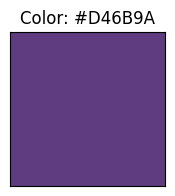

In [35]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_facecolor("#5F3C7F")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Color: #D46B9A", fontsize=12)
plt.show()

## Amplitude only

In [1]:
import qnmfits
import numpy as np
import scipy
import corner
from funcs.likelihood_funcs import *
from funcs.CCE import * 
from funcs.kernel_param_funcs import *
from funcs.GP_funcs import *
from funcs.qnm_selecting_funcs import * 

We start by importing a simulation (as a qnmfits.Custom object). We obtain the remnant mass and spin (which we denote with _0 in code and as a subscript * in the written notes). We also choose a start time for the fit, and modes to include in the model.  

In [2]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")

n_max = 6

T0 = 17
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

Next, we determine the least squares amplitudes. The C_0 list can be used when we include Mf and/or Chif as parameters (otherwise it isn't needed). We hereafter treat the real and imaginary QNM amplitude as separate parameters, included in sequence in the true_params list. 

In [3]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=T0,
    T=T,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

ref_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    ref_params.append(re_c)
    ref_params.append(im_c)

The kernel parameters are pre-saved in the tuned_params file. However, for the white noise, these need to be computed using the tuned value. 

In [4]:
# Get the standard kernel parameters

with open('tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)

tuned_param_dict_main = params[id]

In [5]:
# The training / tuning is demonstrated in the `get_kernel_params` file and notebook. 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3239257812499994]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

We now use the QNM BGP fit to do Bayesian fit with our chosen kernels

In [ ]:
# White noise kernel

fit_wn = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
        include_chif=True,
        include_Mf=True,
    )

# Standard kernel 

fit_main = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_main,
        kernel_main,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
    )

marginalise

In [20]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]
parameter_choice = [(2,2,0,1)]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, fit_main["mean"], fit_main["fisher_matrix"])
marginal_mean_wn, marginal_fisher_wn = marginalise(parameter_choice, param_list, fit_wn["mean"], fit_wn["fisher_matrix"])

marginal_covariance_main = get_inverse(marginal_fisher_main, epsilon=1e-10) 
marginal_covariance_wn = get_inverse(marginal_fisher_wn, epsilon=1e-10) 

samples_main_marginal = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn_marginal = scipy.stats.multivariate_normal(
    marginal_mean_wn, marginal_covariance_wn, allow_singular=True
).rvs(size=10000)

alternatively, draw from the full posterior then take the first two elements

In [21]:
covariance_main = get_inverse(fit_main["fisher_matrix"])  
covariance_wn = get_inverse(fit_wn["fisher_matrix"])

samples_main = scipy.stats.multivariate_normal(
    fit_main["mean"], covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn  = scipy.stats.multivariate_normal(
    fit_wn["mean"], covariance_wn, allow_singular=True
).rvs(size=10000)

samples_main_full = samples_main[:,indices]
samples_wn_full = samples_wn[:,indices]

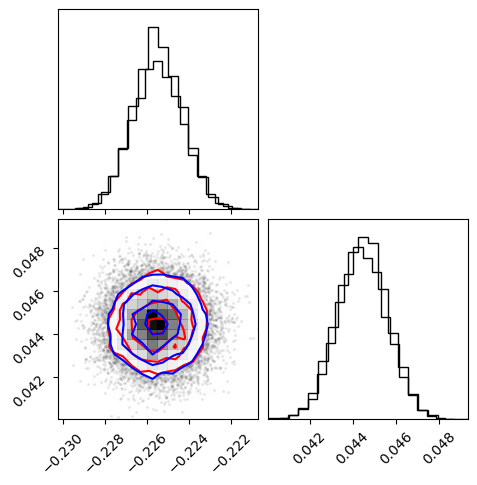

In [22]:
figure = corner.corner(
    samples_wn_full,
    colors='red',
    plot_contours=True,
    contour_kwargs={"colors": "red"},
)

figure2 = corner.corner(
    samples_wn_marginal,
    fig=figure,
    plot_contours=True,
    contour_kwargs={"colors": "blue"},
)

Let's marginalise out the overtones above $n=1$.

In [10]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]
parameter_choice = [(2,2,0,1), (2,2,1,1)]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, fit_main["mean"], fit_main["fisher_matrix"])
marginal_mean_wn, marginal_fisher_wn = marginalise(parameter_choice, param_list, fit_wn["mean"], fit_wn["fisher_matrix"])

marginal_covariance_main = get_inverse(marginal_fisher_main, epsilon=1e-10) 
marginal_covariance_wn = get_inverse(marginal_fisher_wn, epsilon=1e-10) 

In [11]:
samples_main = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn = scipy.stats.multivariate_normal(
    marginal_mean_wn, marginal_covariance_wn, allow_singular=True
).rvs(size=10000)

In [12]:
labels = [
    r"$\mathrm{Re}(A_{(2,2,0,1)})$",
    r"$\mathrm{Im}(A_{(2,2,0,1)})$",
    r"$\mathrm{Re}(A_{(2,2,7,1)})$",
    r"$\mathrm{Im}(A_{(2,2,7,1)})$",
]

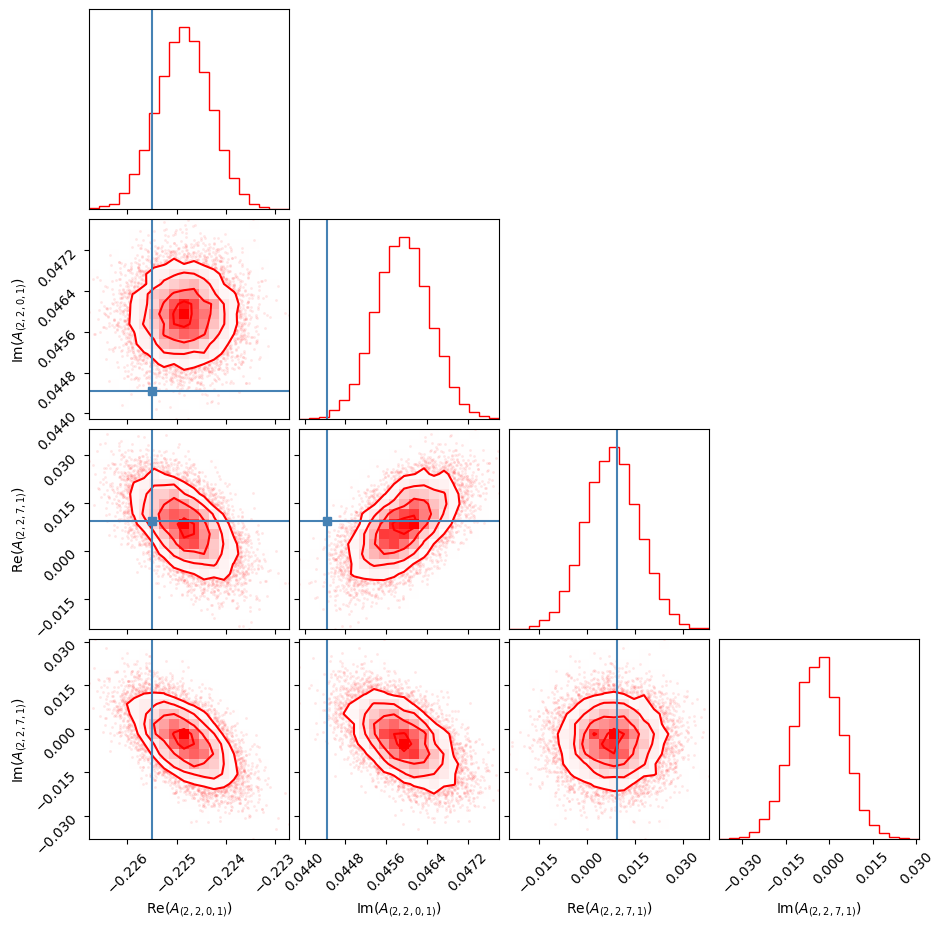

In [13]:
figure = corner.corner(
    samples_main,
    color='red',
    truths=[ref_params[i] for i in indices],
    labels=labels,
)

and compare to the white noise case (which gives MAP values identical to least squares values) 

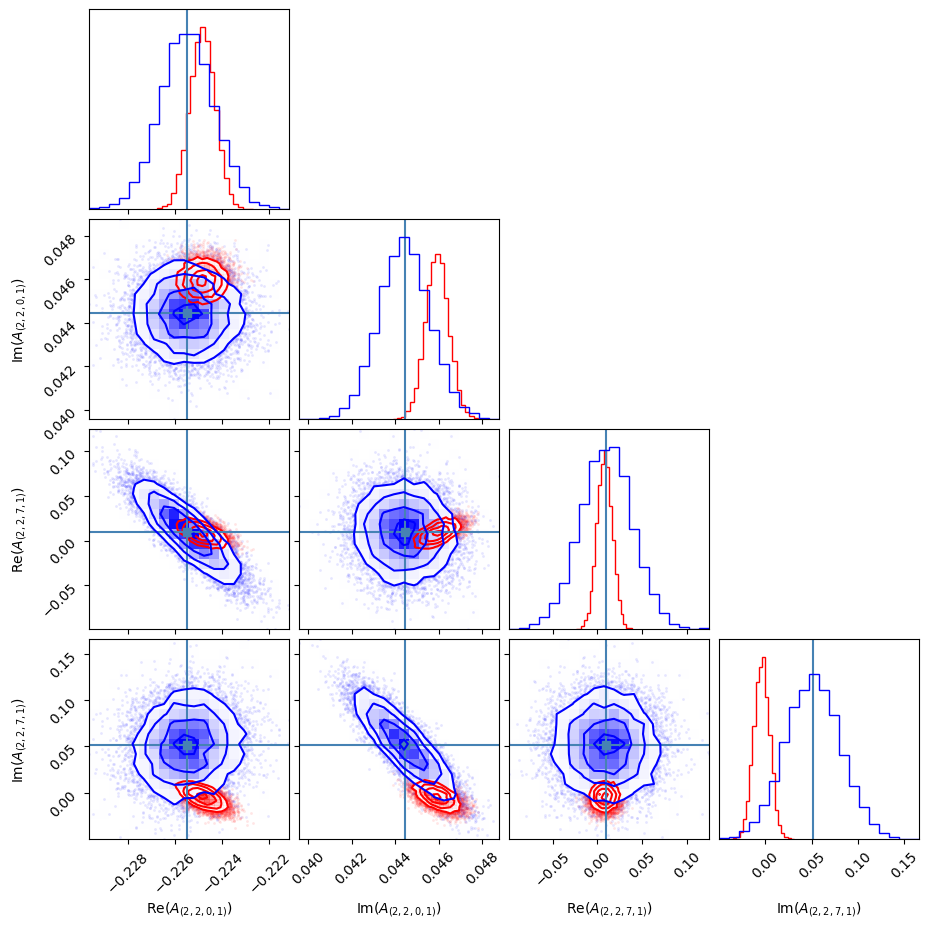

In [14]:
figure = corner.corner(
    samples_main,
    color='red',
    truths=[ref_params[i] for i in indices],
    labels=labels,
)

figure = corner.corner(
    samples_wn,
    color='blue',
    labels=labels,
    fig=figure
)

## Including mass and spin

We can also include the mass and spin as parameters in the model. In practise they are included as the final two elements in parameter lists:

$[\rm Re(A_1), \rm Im(A_1), \rm Re(A_2), \rm Im(A_2), \dots, \chi_f, M_f]$.

To include these, set the appropriate boolean arguments in get_fisher_matrix, get_b_vector. C_0 also needs to be set to the the list obtained from the least-squares fit, and the true_param values need to be added to the mean vector.  The reason for avoiding these in the amplitude-only case is to save us having to compute the least-squares fit (because, in this case, only $M_*$ and $\chi_*$ are needed). 

In [15]:
fit = qnm_BGP_fit(
    sim_main.times,
    sim_main.h,
    qnm_list,
    Mf_0,
    chif_mag_0,
    T0,
    tuned_param_dict_main,
    kernel_main,
    t0_method="geq",
    T=T,
    spherical_modes=spherical_modes,
    include_chif=True,
    include_Mf=True,
)

In [16]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] + ["chif"] + ["Mf"]
ref_params_full = ref_params + [chif_mag_0, Mf_0]
parameter_choice = ["chif", "Mf"]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, fit['mean'], fit['fisher_matrix'])
marginal_covariance_main = get_inverse(marginal_fisher_main, epsilon=1e-10)

In [17]:
samples = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

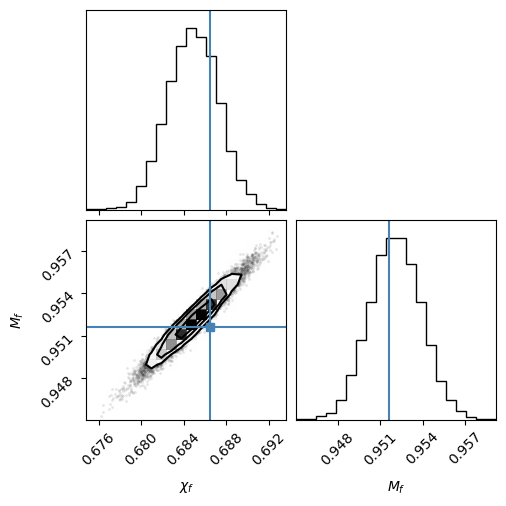

In [18]:
labels = [
    r"$\chi_f$",
    r"$M_f$",
]

figure = corner.corner(
    samples,
    truths=[ref_params_full[i] for i in indices],
    labels=labels,
)